<a href="https://colab.research.google.com/github/Detoyyy/PengolahanCitra/blob/main/PROJECT_UTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Latihan 1: Smoothing spasial vs frekuensi (Citra Lenna )

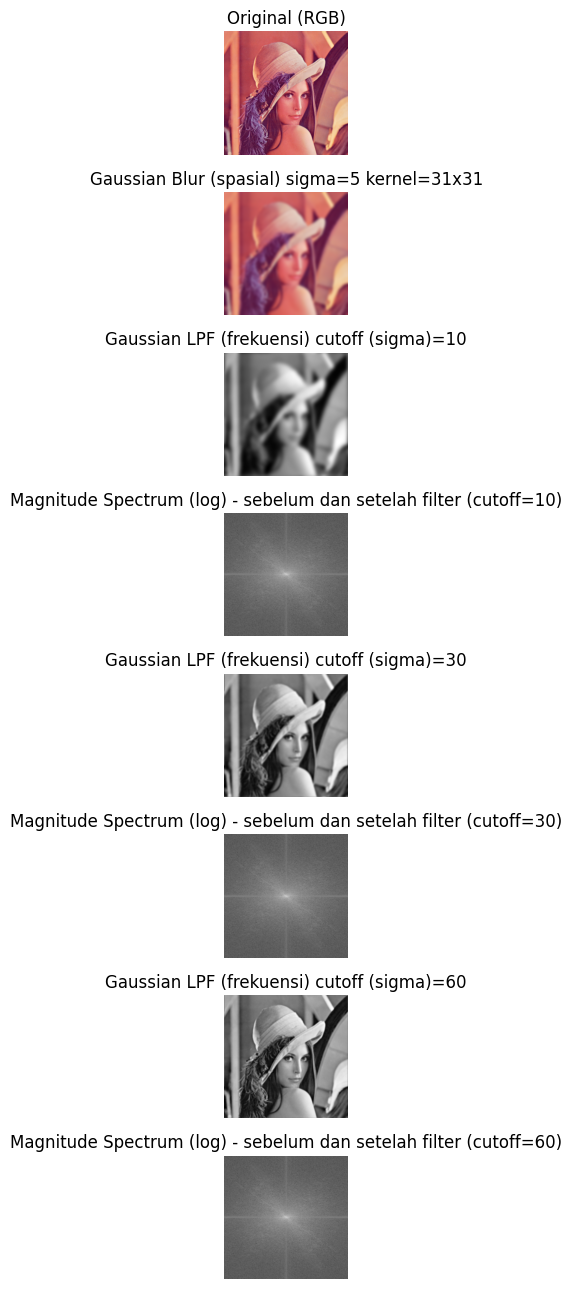

Metrics (MSE, PSNR[dB], SSIM):
spatial_sigma_5           -> MSE=0.004154, PSNR=23.815 dB, SSIM=0.6627
freq_cutoff_10            -> MSE=0.007198, PSNR=21.428 dB, SSIM=0.5923
freq_cutoff_30            -> MSE=0.002308, PSNR=26.368 dB, SSIM=0.7604
freq_cutoff_60            -> MSE=0.000899, PSNR=30.464 dB, SSIM=0.8786

Semua hasil disimpan di folder: lenna_results


In [ ]:
# smoothing_lenna_analysis.py
import os
import io
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

# -------- konfigurasi --------
url_raw = "https://raw.githubusercontent.com/lenna-project/ultraface-plugin/main/assets/lenna.png"
out_dir = "lenna_results"
os.makedirs(out_dir, exist_ok=True)

# Gaussian spasial sigma (untuk contoh)
sigma_spatial = 5  # coba ubah: 1,2,5,10

# cutoff untuk Gaussian LPF di frekuensi (kita akan pakai sebagai sigma frequency dalam pixels)
cutoffs = [10, 30, 60]

# ukuran kernel Gaussian spasial -> gunakan odd dan relatif ke sigma
def gaussian_kernel_size(sigma):
    k = int(2*np.ceil(3*sigma) + 1)
    if k % 2 == 0:
        k += 1
    return k

# -------- helper image IO --------
def download_image(url):
    resp = urllib.request.urlopen(url)
    data = resp.read()
    arr = np.asarray(bytearray(data), dtype=np.uint8)
    img = cv2.imdecode(arr, cv2.IMREAD_COLOR)  # BGR
    return img

# -------- frequency-domain Gaussian LPF mask --------
def gaussian_lpf_mask(shape, sigma):
    # shape: (rows, cols)
    rows, cols = shape
    crow, ccol = rows//2, cols//2
    # create distance grid
    y = np.arange(0, rows) - crow
    x = np.arange(0, cols) - ccol
    X, Y = np.meshgrid(x, y)
    D2 = X**2 + Y**2
    H = np.exp(-D2 / (2 * (sigma**2)))
    return H

# -------- frequency filtering function --------
def apply_frequency_gaussian_lpf(img_gray, sigma):
    # img_gray: float in [0,1] or uint8
    rows, cols = img_gray.shape
    # FFT
    f = np.fft.fft2(img_gray)
    fshift = np.fft.fftshift(f)
    # mask
    H = gaussian_lpf_mask((rows, cols), sigma)
    # apply
    G = fshift * H
    # inverse
    g_ishift = np.fft.ifftshift(G)
    img_back = np.fft.ifft2(g_ishift)
    img_back = np.real(img_back)
    return img_back, H, fshift, G

# -------- metrics wrapper --------
def compute_metrics(ref, test):
    # ensure float64 in [0,1]
    ref_f = ref.astype(np.float64)
    test_f = test.astype(np.float64)
    # if uint8 (0-255), keep scale consistent
    if ref_f.max() > 1.0:
        ref_f /= 255.0
        test_f /= 255.0
    mse = mean_squared_error(ref_f, test_f)
    psnr = peak_signal_noise_ratio(ref_f, test_f, data_range=1.0)
    ssim = structural_similarity((ref_f*255).astype(np.uint8), (test_f*255).astype(np.uint8), multichannel=False)
    return mse, psnr, ssim

# -------- main pipeline --------
orig_bgr = download_image(url_raw)
if orig_bgr is None:
    raise RuntimeError("Gagal mengunduh citra. Cek koneksi atau URL.")
orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)
orig_gray = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2GRAY)

# Normalisasi untuk frequency processing
orig_gray_f = orig_gray.astype(np.float64)

# 1) Gaussian blur - spatial
k = gaussian_kernel_size(sigma_spatial)
blur_spatial = cv2.GaussianBlur(orig_rgb, (k,k), sigmaX=sigma_spatial, sigmaY=sigma_spatial)

# Convert to gray for fair comparison metrics (use luminance from RGB)
def rgb_to_gray_uint8(rgb):
    return cv2.cvtColor(rgb.astype(np.uint8), cv2.COLOR_RGB2GRAY)

blur_spatial_gray = rgb_to_gray_uint8(blur_spatial)

# 2) Gaussian LPF in frequency for each cutoff
freq_results = {}
for cutoff in cutoffs:
    img_back, H, fshift, G = apply_frequency_gaussian_lpf(orig_gray_f, sigma=cutoff)
    # Clip and convert to uint8
    img_back_clipped = np.clip(img_back, 0, 255)
    img_back_uint8 = img_back_clipped.astype(np.uint8)
    freq_results[cutoff] = {
        "img": img_back_uint8,
        "H": H,
        "Fshift": fshift,
        "G": G
    }

# 3) Visualisasi: original, spatial blur, each freq result, plus magnitude spectrums
n_plots = 2 + len(cutoffs)*2  # original, spatial, for each cutoff: freq image + magnitude spectrum
plt.figure(figsize=(12, 4 + 3*len(cutoffs)))

# original
plt.subplot(n_plots, 1, 1)
plt.imshow(orig_rgb)
plt.title("Original (RGB)")
plt.axis('off')

# spatial blur
plt.subplot(n_plots, 1, 2)
plt.imshow(blur_spatial)
plt.title(f"Gaussian Blur (spasial) sigma={sigma_spatial} kernel={k}x{k}")
plt.axis('off')

# per-cutoff displays
row = 3
for cutoff in cutoffs:
    r = freq_results[cutoff]
    # freq-domain result image
    plt.subplot(n_plots, 1, row)
    plt.imshow(r["img"], cmap='gray')
    plt.title(f"Gaussian LPF (frekuensi) cutoff (sigma)={cutoff}")
    plt.axis('off')
    row += 1

    # magnitude spectrum (log)
    mag = np.log(1 + np.abs(r["Fshift"]))
    # normalize for display
    mag = (mag - mag.min()) / (mag.max() - mag.min())
    plt.subplot(n_plots, 1, row)
    plt.imshow(mag, cmap='gray')
    plt.title(f"Magnitude Spectrum (log) - sebelum dan setelah filter (cutoff={cutoff})")
    plt.axis('off')
    row += 1

plt.tight_layout()
plt.savefig(os.path.join(out_dir, "visual_summary.png"), dpi=150)
plt.show()

# 4) Compute metrics: compare gray original with spatial blur gray and each freq result
orig_gray_u8 = orig_gray.copy()
metrics = {}

# spatial metrics
mse_s, psnr_s, ssim_s = compute_metrics(orig_gray_u8, blur_spatial_gray)
metrics["spatial_sigma_"+str(sigma_spatial)] = (mse_s, psnr_s, ssim_s)

# freq metrics
for cutoff in cutoffs:
    img_test = freq_results[cutoff]["img"]
    mse_f, psnr_f, ssim_f = compute_metrics(orig_gray_u8, img_test)
    metrics[f"freq_cutoff_{cutoff}"] = (mse_f, psnr_f, ssim_f)

# Tampilan tabel
print("Metrics (MSE, PSNR[dB], SSIM):")
for k,v in metrics.items():
    print(f"{k:25s} -> MSE={v[0]:.6f}, PSNR={v[1]:.3f} dB, SSIM={v[2]:.4f}")

# Simpan hasil citra terpisah
cv2.imwrite(os.path.join(out_dir, "orig_rgb.png"), cv2.cvtColor(orig_rgb, cv2.COLOR_RGB2BGR))
cv2.imwrite(os.path.join(out_dir, "blur_spatial.png"), cv2.cvtColor(blur_spatial, cv2.COLOR_RGB2BGR))
for cutoff in cutoffs:
    cv2.imwrite(os.path.join(out_dir, f"freq_lpf_cutoff_{cutoff}.png"), freq_results[cutoff]["img"])

print(f"\nSemua hasil disimpan di folder: {out_dir}")


Latihan 2: Sharpening Laplacian vs HPF (Citra Moon)

Saving ft.jpg to ft.jpg
                      Metode  PSNR (dB)      SSIM
0       Sharpening Laplacian   6.039126  0.600713
1  High-Pass Gaussian (Freq)  26.348410  0.949460


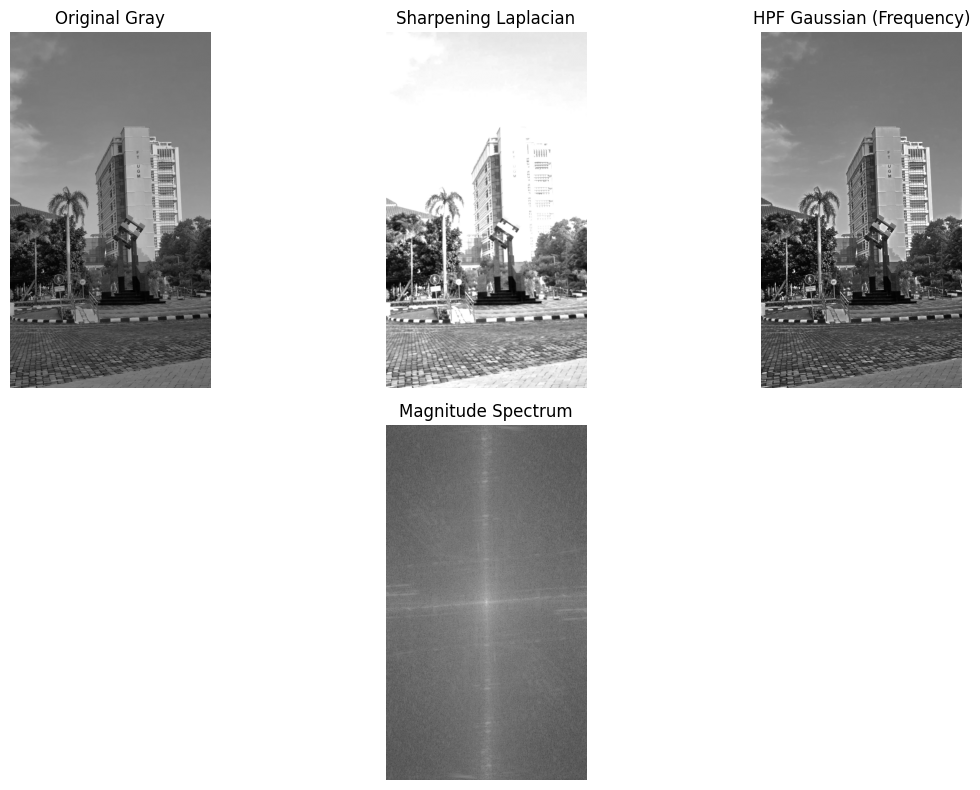

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from google.colab import files
import pandas as pd

# ===========================================
# UPLOAD IMAGE
# ===========================================
uploaded = files.upload()
filename = list(uploaded.keys())[0]

img = cv2.imread(filename)
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ===========================================
# 1. SHARPENING LAPLACIAN (SPATIAL)
# ===========================================
lap = cv2.Laplacian(gray, cv2.CV_64F, ksize=3)
lap_norm = cv2.normalize(lap, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
sharp_lap = cv2.addWeighted(gray, 1, lap_norm, 1, 0)


# ===========================================
# 2. HIGH-PASS GAUSSIAN (FREQUENCY DOMAIN)
# ===========================================
def gaussian_hpf(img, sigma):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2
    y, x = np.ogrid[:rows, :cols]
    X = x - ccol
    Y = y - crow

    D2 = X*X + Y*Y
    H = 1 - np.exp(-D2 / (2 * sigma * sigma))

    G = fshift * H
    img_back = np.fft.ifft2(np.fft.ifftshift(G))
    img_back = np.real(img_back)

    return np.clip(img_back, 0, 255).astype(np.uint8), fshift, H, G

sharp_hpf, Fshift, H, G = gaussian_hpf(gray, sigma=20)
sharp_hpf = cv2.addWeighted(gray, 1, sharp_hpf, 1, 0)


# ===========================================
# METRICS (PSNR & SSIM)
# ===========================================
PSNR_lap = peak_signal_noise_ratio(gray, sharp_lap, data_range=255)
SSIM_lap = structural_similarity(gray, sharp_lap)

PSNR_hpf = peak_signal_noise_ratio(gray, sharp_hpf, data_range=255)
SSIM_hpf = structural_similarity(gray, sharp_hpf)


# ===========================================
# BUILD METRIC TABLE
# ===========================================
data = {
    "Metode": ["Sharpening Laplacian", "High-Pass Gaussian (Freq)"],
    "PSNR (dB)": [PSNR_lap, PSNR_hpf],
    "SSIM": [SSIM_lap, SSIM_hpf]
}
df = pd.DataFrame(data)
print(df)


# ===========================================
# MAGNITUDE SPECTRUM VISUALIZATION
# ===========================================
mag = np.log(1 + np.abs(Fshift))
mag = (mag - mag.min()) / (mag.max() - mag.min())


# ===========================================
# FINAL VISUALIZATION
# ===========================================
plt.figure(figsize=(12,8))

plt.subplot(2,3,1)
plt.imshow(gray, cmap="gray")
plt.title("Original Gray")
plt.axis("off")

plt.subplot(2,3,2)
plt.imshow(sharp_lap, cmap="gray")
plt.title("Sharpening Laplacian")
plt.axis("off")

plt.subplot(2,3,3)
plt.imshow(sharp_hpf, cmap="gray")
plt.title("HPF Gaussian (Frequency)")
plt.axis("off")

plt.subplot(2,3,5)
plt.imshow(mag, cmap="gray")
plt.title("Magnitude Spectrum")
plt.axis("off")

plt.tight_layout()
plt.show()




Latihan 3:Artefak ringing (Citra Camera Man)

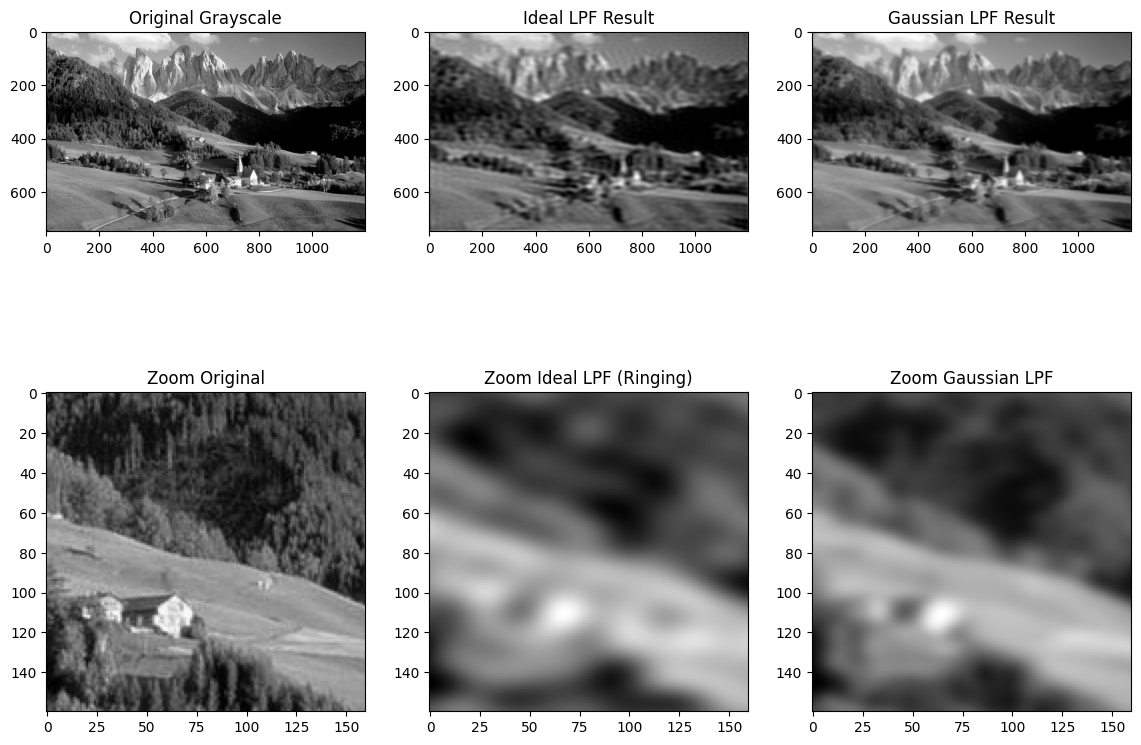

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import math
import pandas as pd

# ============================================
# Load Image
# ============================================
img = cv2.imread('/content/pemandangan gunung.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)

# FFT
F = np.fft.fft2(img_gray)
Fshift = np.fft.fftshift(F)

# --------------------------------------------
# IDEAL LOW PASS FILTER
# --------------------------------------------
def ideal_lpf(shape, cutoff):
    P, Q = shape
    H = np.zeros((P, Q), np.float32)
    centerX, centerY = P//2, Q//2
    for u in range(P):
        for v in range(Q):
            D = np.sqrt((u-centerX)**2 + (v-centerY)**2)
            if D <= cutoff:
                H[u,v] = 1
    return H

# --------------------------------------------
# GAUSSIAN LOW PASS FILTER
# --------------------------------------------
def gaussian_lpf(shape, cutoff):
    P, Q = shape
    H = np.zeros((P,Q), np.float32)
    centerX, centerY = P//2, Q//2
    for u in range(P):
        for v in range(Q):
            D = np.sqrt((u-centerX)**2 + (v-centerY)**2)
            H[u,v] = np.exp(-(D**2)/(2*(cutoff**2)))
    return H

# Cutoff Radius
cutoff = 40

# Filtering
H_ideal = ideal_lpf(img_gray.shape, cutoff)
H_gauss = gaussian_lpf(img_gray.shape, cutoff)

ideal_filtered = np.abs(np.fft.ifft2(np.fft.ifftshift(Fshift * H_ideal)))
gauss_filtered = np.abs(np.fft.ifft2(np.fft.ifftshift(Fshift * H_gauss)))

# --------------------------------------------
# Hitung MSE, PSNR, SSIM
# --------------------------------------------
def mse(imgA, imgB):
    return np.mean((imgA - imgB)**2)

def psnr(mse):
    return 10 * math.log10((255**2) / mse)

MSE_ideal = mse(img_gray, ideal_filtered)
MSE_gauss = mse(img_gray, gauss_filtered)

PSNR_ideal = psnr(MSE_ideal)
PSNR_gauss = psnr(MSE_gauss)

SSIM_ideal = ssim(img_gray, ideal_filtered, data_range=ideal_filtered.max()-ideal_filtered.min())
SSIM_gauss = ssim(img_gray, gauss_filtered, data_range=gauss_filtered.max()-gauss_filtered.min())

# --------------------------------------------
# Zoom Edge Area (untuk melihat ringing)
# otomatis crop bagian tengah
# --------------------------------------------
h, w = img_gray.shape
zoom = (slice(h//2-80, h//2+80), slice(w//2-80, w//2+80))

# --------------------------------------------
# Visualisasi
# --------------------------------------------
plt.figure(figsize=(14,10))

plt.subplot(231); plt.imshow(img_gray, cmap='gray'); plt.title("Original Grayscale")
plt.subplot(232); plt.imshow(ideal_filtered, cmap='gray'); plt.title("Ideal LPF Result")
plt.subplot(233); plt.imshow(gauss_filtered, cmap='gray'); plt.title("Gaussian LPF Result")

plt.subplot(234); plt.imshow(img_gray[zoom], cmap='gray'); plt.title("Zoom Original")
plt.subplot(235); plt.imshow(ideal_filtered[zoom], cmap='gray'); plt.title("Zoom Ideal LPF (Ringing)")
plt.subplot(236); plt.imshow(gauss_filtered[zoom], cmap='gray'); plt.title("Zoom Gaussian LPF")

plt.show()




Latihan 4: Denoising + Canny (Citra Coins)

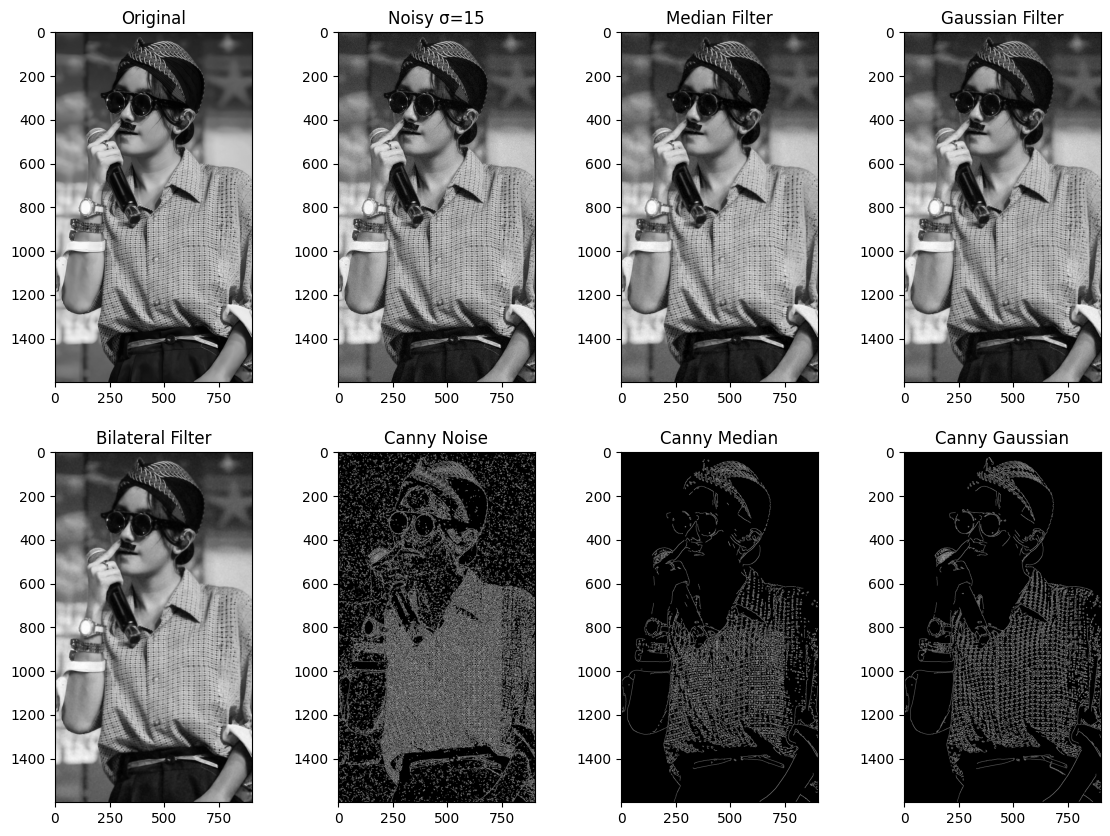

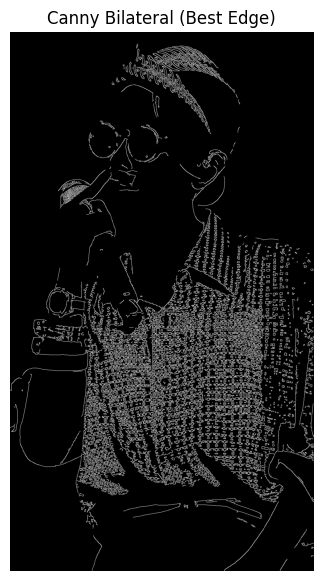

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread('/content/ndoro.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)

# ============================================
# noise Gaussian sigma = 15
# ============================================
sigma = 15
noise = np.random.normal(0, sigma, gray.shape)
noisy = gray + noise
noisy = np.clip(noisy, 0, 255).astype(np.uint8)

# ============================================
# Denoising filters
# ============================================
median_filtered = cv2.medianBlur(noisy, 5)
gaussian_filtered = cv2.GaussianBlur(noisy, (5,5), 1.2)
bilateral_filtered = cv2.bilateralFilter(noisy, 9, 75, 75)

# ============================================
# Canny Edge detection
# ============================================
canny_orig = cv2.Canny(gray.astype(np.uint8), 100, 200)
canny_noisy = cv2.Canny(noisy, 100, 200)
canny_median = cv2.Canny(median_filtered, 100, 200)
canny_gaussian = cv2.Canny(gaussian_filtered, 100, 200)
canny_bilateral = cv2.Canny(bilateral_filtered, 100, 200)

# ============================================
# Visualisasi
# ============================================
plt.figure(figsize=(14,10))
plt.subplot(2,4,1); plt.imshow(gray, cmap='gray'); plt.title("Original")
plt.subplot(2,4,2); plt.imshow(noisy, cmap='gray'); plt.title("Noisy σ=15")
plt.subplot(2,4,3); plt.imshow(median_filtered, cmap='gray'); plt.title("Median Filter")
plt.subplot(2,4,4); plt.imshow(gaussian_filtered, cmap='gray'); plt.title("Gaussian Filter")
plt.subplot(2,4,5); plt.imshow(bilateral_filtered, cmap='gray'); plt.title("Bilateral Filter")

plt.subplot(2,4,6); plt.imshow(canny_noisy, cmap='gray'); plt.title("Canny Noise")
plt.subplot(2,4,7); plt.imshow(canny_median, cmap='gray'); plt.title("Canny Median")
plt.subplot(2,4,8); plt.imshow(canny_gaussian, cmap='gray'); plt.title("Canny Gaussian")

plt.figure(figsize=(7,7))
plt.imshow(canny_bilateral, cmap='gray')
plt.title("Canny Bilateral (Best Edge)")
plt.axis("off")
plt.show()
